In [29]:
import torch
from d2l import torch as d2l
from torch import nn

In [30]:
torch.cuda.device_count()

0

In [31]:
torch.device('mps')


device(type='mps')

In [43]:
def try_gpu(i=0): #@save
    return torch.device('mps')

In [33]:
x = torch.tensor([1,2,3])
x.device

device(type='cpu')

In [36]:
x = torch.ones(2, 3, device=try_gpu())

In [37]:
x.device

device(type='mps', index=0)

In [41]:
device = torch.device('mps')

In [42]:
device

device(type='mps')

In [13]:
x

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='mps:0')

In [14]:
import torch
from torch import nn
from d2l import torch as d2l

In [16]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size = 5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))


In [17]:
X = torch.rand(size = (1, 1, 28, 28), dtype = torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [18]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [22]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0]/metric[1]

In [27]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weight(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)
    print(f'training on {device}')
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start();
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i+1) % (num_epochs // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i+1) / num_batches, (train_l ,train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.471, train acc 0.823, test acc 0.809
23130.6 examples/sec on mps


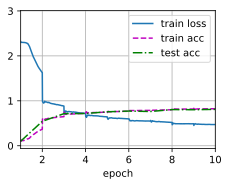

In [28]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter,num_epochs, lr, try_gpu())